In [1]:
from keras.layers import Input,Dense,Activation
from keras.layers import Conv2D,MaxPooling2D,Lambda,Dropout,Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint
from keras.models import Model
from keras.models import load_model
from keras import regularizers
from keras import backend as K
from keras.layers.normalization import BatchNormalization

import h5py
import time

Using TensorFlow backend.


# Basic Model

## Load dataset

In [2]:
# load data
import h5py

h5f = h5py.File('./data/train.h5','r')
%time X_train = h5f['image'][:]
%time y_train = h5f['steering'][:]
h5f.close()

h5f2 = h5py.File('./data/test.h5','r')
%time X_test = h5f2['image'][:]
%time y_test = h5f2['steering'][:]
h5f2.close()

CPU times: user 39.6 ms, sys: 9.45 s, total: 9.49 s
Wall time: 16.1 s
CPU times: user 2.07 ms, sys: 6.03 ms, total: 8.1 ms
Wall time: 24.9 ms
CPU times: user 5.52 ms, sys: 1.05 s, total: 1.05 s
Wall time: 2 s
CPU times: user 1.1 ms, sys: 533 µs, total: 1.63 ms
Wall time: 2.62 ms


## Build model

In [2]:
def build_model(inputs_shape=None, activation='relu', optimizer = 'adam', loss='mse'):
    
    image_input = Input(shape=inputs_shape[1:])
    # use strided convolutions in the ﬁrst three convolutional layers with a 2×2 stride and a 5×5 kernel and 
    x = Conv2D(24,(5,5),strides=(2,2),activation='relu',padding='valid')(image_input)
    x = Conv2D(36,(5,5),strides=(2,2),activation='relu',padding='valid')(x)
#     x = MaxPooling2D((2,2))(x)
    x = Conv2D(48,(5,5),strides=(2,2),activation='relu',padding='valid')(x)
    
    
#     # a non-strided convolution with a 3×3 kernel size in the last two convolutional layers
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
#     x = MaxPooling2D((2,2))(x)
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Flatten()(x)
    x = Dense(100,activation='relu')(x)
    x = Dense(50,activation='relu')(x)
    x = Dense(10,activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inputs=image_input, outputs=out)
    model.compile(optimizer=optimizer, loss =loss)
    
    return model


In [54]:
X_train.shape

(24300, 66, 200, 3)

In [4]:
# reset graph
K.clear_session()

# model = build_model(inputs_shape=X_train.shape)
model = build_model(inputs_shape=(24300, 66, 200, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

## Train model

In [33]:
#------------ train with early stop --------------
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint


filepath="./models/base_{val_loss:.3f}.h5"
callbacks = [EarlyStopping(monitor='val_loss',patience=5),
             ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True)]    

model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.1,callbacks=callbacks,shuffle="batch")
scores = model1.evaluate(X_test, y_test_label, verbose=0)

Train on 21870 samples, validate on 2430 samples
Epoch 1/20
21870/21870 [==============================] - 287s - loss: 11.6652 - val_loss: 3.2986
Epoch 2/20
21870/21870 [==============================] - 254s - loss: 1.5485 - val_loss: 0.7466
Epoch 3/20
21870/21870 [==============================] - 250s - loss: 0.7658 - val_loss: 0.6074
Epoch 4/20
  704/21870 [..............................] - ETA: 271s - loss: 0.9753

KeyboardInterrupt: 

In [36]:

from keras.models import load_model

model_load = load_model('./models/base_0.747.h5')
model_load.evaluate(X_test, y_test)

2700/2700 [==============================] - 11s    


2.9817809388372631

# Refine model

## Using RBG

In [ ]:
def build_model(inputs_shape=None, activation='relu', optimizer = 'adam', loss='mse'):

# reset graph
K.clear_session()

model = build_model(inputs_shape=X_train.shape)
model.summary()    

In [56]:
inputs_shape = X_train.shape

model_names = ['basic','BN', 'pool','drop','smallkernel','RGB']
models = [build_model(inputs_shape=inputs_shape),
         build_model_BN(inputs_shape=inputs_shape),
         build_model_pool(inputs_shape=inputs_shape),
         build_model_drop(inputs_shape=inputs_shape),
         build_model_small(inputs_shape=inputs_shape),
         build_model(inputs_shape=inputs_shape)]

train_histories=[]
for model_name, model in zip(model_names, models):
    filepath="./models/"+model_name + "{epoch:2d}_{val_loss:.3f}.h5"
    callbacks = [EarlyStopping(monitor='val_loss',patience=5),
                 ModelCheckpoint(filepath, monitor='val_loss',save_best_only=False)]    
    print("---------------------------training model {}----------------------\n".format(model_name))
    if model_name!='RGB':
#         if (not X_train.any()) or (not y_train):
#             del X_trainRGB
#             del y_trainRGB
        
#             h5f = h5py.File('data/train.h5','r')
#             X_train = h5f['image'][:]
#             y_train = h5f['steering'][:]
#             h5f.close()

        start_time = time.time()
        his = model.fit(X_train, y_train,epochs=20,batch_size=64,validation_split=0.15,callbacks=callbacks,shuffle="batch")
        end_time = time.time()
        score = model.evaluate(X_test, y_test, verbose=0)
        print("------------------------trining model {}, score {}, using time {} \n".format(model_name,score,end_time-start_time))
        train_histories.append(his)
    else:
#         if (not X_trainRGB) or (not y_trainRGB):
        del X_train
        del y_train

        h5f = h5py.File('data/RGBtrain.h5','r')
        X_trainRGB = h5f['image'][:]
        y_trainRGB = h5f['steering'][:]
        h5f.close()

        h5f = h5py.File('data/RGBtest.h5','r')
        X_testRGB = h5f['image'][:]
        y_testRGB = h5f['steering'][:]
        h5f.close()
        
        start_time = time.time()
        his = model.fit(X_trainRGB, y_trainRGB,epochs=20,batch_size=64,validation_split=0.15,callbacks=callbacks,shuffle="batch")
        end_time = time.time()
        score = model.evaluate(X_testRGB, y_testRGB, verbose=0)
        print("------------------------trining model {}, score {}, using time {} \n".format(model_name,score,end_time-start_time))
        train_histories.append(his)

        

---------------------------training model basic----------------------

Train on 20655 samples, validate on 3645 samples
Epoch 1/20
20655/20655 [==============================] - 255s - loss: 12.8659 - val_loss: 4.2837
Epoch 2/20
20655/20655 [==============================] - 239s - loss: 2.1452 - val_loss: 1.1969
Epoch 3/20
20655/20655 [==============================] - 229s - loss: 0.8160 - val_loss: 0.6555
Epoch 4/20
20655/20655 [==============================] - 235s - loss: 0.5081 - val_loss: 0.4802
Epoch 5/20
20655/20655 [==============================] - 215s - loss: 0.4118 - val_loss: 0.4165
Epoch 6/20
20655/20655 [==============================] - 217s - loss: 0.3582 - val_loss: 0.2714
Epoch 7/20
20655/20655 [==============================] - 212s - loss: 0.3051 - val_loss: 0.2665
Epoch 8/20
20655/20655 [==============================] - 208s - loss: 0.2814 - val_loss: 0.4702
Epoch 9/20
20655/20655 [==============================] - 210s - loss: 0.2920 - val_loss: 0.2372
Epoch 

20655/20655 [==============================] - 973s - loss: 11.8340 - val_loss: 2.8978
Epoch 2/20
20655/20655 [==============================] - 955s - loss: 1.9303 - val_loss: 0.9288
Epoch 3/20
20655/20655 [==============================] - 966s - loss: 0.8392 - val_loss: 0.7590
Epoch 4/20
20655/20655 [==============================] - 990s - loss: 0.5028 - val_loss: 0.4158
Epoch 5/20
20655/20655 [==============================] - 971s - loss: 0.4219 - val_loss: 0.2955
Epoch 6/20
20655/20655 [==============================] - 980s - loss: 0.3576 - val_loss: 0.3133
Epoch 7/20
20655/20655 [==============================] - 1093s - loss: 0.2686 - val_loss: 0.2703
Epoch 8/20
20655/20655 [==============================] - 1044s - loss: 0.2829 - val_loss: 0.3045
Epoch 9/20
20655/20655 [==============================] - 1038s - loss: 0.2320 - val_loss: 0.2269
Epoch 10/20
20655/20655 [==============================] - 994s - loss: 0.2644 - val_loss: 0.2435
Epoch 11/20
20655/20655 [===========

In [57]:
len(train_histories)

6

In [58]:

# Visualize training history


import matplotlib.pyplot as plt
import numpy

# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(train_histories[0].history.keys())


dict_keys(['val_loss', 'loss'])


In [64]:
train_histories[0].history

{'loss': [12.865852948892668,
  2.1452265116903515,
  0.81599241910965381,
  0.50808101209420264,
  0.41181428323528491,
  0.35816607826473462,
  0.30513564062678361,
  0.28135196751700969,
  0.29199657938405926,
  0.22048272773086,
  0.2206278509636013,
  0.23613613018095567,
  0.23893074859966235,
  0.23075886265154008,
  0.22087175293699993,
  0.1529453416246965,
  0.17875619289575492,
  0.19493860894269904,
  0.15132823939027351,
  0.15052797779408417],
 'val_loss': [4.2836828612496332,
  1.1969487054848376,
  0.6554765456007341,
  0.48017196768922898,
  0.41652746171127131,
  0.27144998776405765,
  0.26651854777532352,
  0.47015520037446984,
  0.23719617249380251,
  0.21843116202472168,
  0.28918603862264031,
  0.18344750026207729,
  0.19846771963666332,
  0.30370058066151595,
  0.18394786227795976,
  0.15182830252683374,
  0.31497174452361748,
  0.1463180857757809,
  0.17157865615129797,
  0.19010438291951298]}

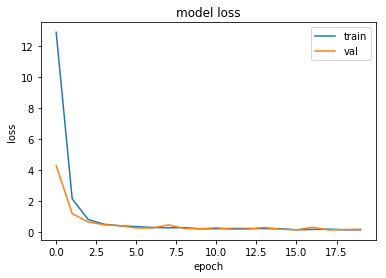

In [61]:
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(train_histories[0].history['loss'])
plt.plot(train_histories[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


## Add Batch Normalization

In [2]:
def build_model_BN(inputs_shape=None, activation='relu', optimizer = 'adam', loss='mse'):
    
    image_input = Input(shape=inputs_shape[1:])
    # use strided convolutions in the ﬁrst three convolutional layers with a 2×2 stride and a 5×5 kernel and 
    x = Conv2D(24,(5,5),strides=(2,2),padding='valid')(image_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    x = Conv2D(36,(5,5),strides=(2,2),padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
#     x = MaxPooling2D((2,2))(x)
    x = Conv2D(48,(5,5),strides=(2,2),padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    
    
#     # a non-strided convolution with a 3×3 kernel size in the last two convolutional layers
    x = Conv2D(64,(3,3),strides=(1,1),padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
#     x = MaxPooling2D((2,2))(x)
    x = Conv2D(64,(3,3),strides=(1,1),padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    
    x = Flatten()(x)
    x = Dense(100)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation)(x)
    
    x = Dense(50)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation)(x)
    
    x = Dense(10)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation)(x)
    
    out = Dense(1)(x)
    
    model = Model(inputs=image_input, outputs=out)
    model.compile(optimizer=optimizer, loss =loss)
    
    return model


In [4]:
K.clear_session()

# model = build_model(inputs_shape=X_train.shape)
model = build_model_BN(inputs_shape=(24300, 66, 200, 3))
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 47, 36)        0         
__________

## Using stride=1 and max pooling

In [10]:
def build_model_pool(inputs_shape=None, activation='relu', optimizer = 'adam', loss='mse'):
    
    image_input = Input(shape=inputs_shape[1:])
    # use strided convolutions in the ﬁrst three convolutional layers with a 2×2 stride and a 5×5 kernel and 
    x = Conv2D(24,(5,5),strides=(1,1),activation='relu',padding='same')(image_input)
    x = MaxPooling2D((2,2))(x)    
    x = Conv2D(36,(5,5),strides=(1,1),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(48,(5,5),strides=(1,1),activation='relu',padding='valid')(x)
    x = MaxPooling2D((2,2))(x)
    
    
#     # a non-strided convolution with a 3×3 kernel size in the last two convolutional layers
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Flatten()(x)
    x = Dense(100,activation='relu')(x)
    x = Dense(50,activation='relu')(x)
    x = Dense(10,activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inputs=image_input, outputs=out)
    model.compile(optimizer=optimizer, loss =loss)
    
    return model

In [50]:
K.clear_session()

model = build_model_pool(inputs_shape=X_train.shape)
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 200, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 100, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 100, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 50, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 46, 48)        43248     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 23, 48)         0         
__________

## Add Dropout

In [25]:
def build_model_drop(inputs_shape=None, activation='relu', optimizer = 'adam', loss='mse'):
    
    image_input = Input(shape=inputs_shape[1:])
    # use strided convolutions in the ﬁrst three convolutional layers with a 2×2 stride and a 5×5 kernel and 
    x = Conv2D(24,(5,5),strides=(2,2),activation='relu',padding='valid')(image_input)
    x = Conv2D(36,(5,5),strides=(2,2),activation='relu',padding='valid')(x)
    x = Conv2D(48,(5,5),strides=(2,2),activation='relu',padding='valid')(x)
    x = Dropout(0.2)(x)
    
    
#     # a non-strided convolution with a 3×3 kernel size in the last two convolutional layers
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(100,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50,activation='relu')(x)
    x = Dense(10,activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inputs=image_input, outputs=out)
    model.compile(optimizer=optimizer, loss =loss)
    
    return model

In [26]:
K.clear_session()

model = build_model_drop(inputs_shape=X_train.shape)
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
__________

## 2\*(3\*3)conv -> (5\*5) conv

In [33]:
def build_model_small(inputs_shape=None, activation='relu', optimizer = 'adam', loss='mse'):
    
    image_input = Input(shape=inputs_shape[1:])
    # use strided convolutions in the ﬁrst three convolutional layers with a 2×2 stride and a 5×5 kernel and 
    x = Conv2D(24,(3,3),strides=(1,1),activation='relu',padding='valid')(image_input)
    x = Conv2D(24,(3,3),strides=(1,1),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2))(x)    
    x = Conv2D(36,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Conv2D(36,(3,3),strides=(1,1),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(48,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Conv2D(48,(3,3),strides=(1,1),activation='relu',padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    
    # a non-strided convolution with a 3×3 kernel size in the last two convolutional layers
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = Flatten()(x)
    x = Dense(100,activation='relu')(x)
    x = Dense(50,activation='relu')(x)
    x = Dense(10,activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inputs=image_input, outputs=out)
    model.compile(optimizer=optimizer, loss =loss)
    
    return model

In [34]:
K.clear_session()

model = build_model_small(inputs_shape=X_train.shape)
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 198, 24)       672       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 198, 24)       5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 99, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 97, 36)        7812      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 97, 36)        11700     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 48, 36)        0         
__________

## Inception block

## conv -> fc   

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Refine basic model+ dropout+BN

## Grid Search

考虑到计算资源有限，对模型先进行超参数网格搜索调优，缩小范围后再进行随机搜索调优。    
调优参数: 
* dropout rate：(0.1, 0.2, 0.3)
* learning rate：(0.001，0.01，0.05)，
Train epoch number: 30; Early stop: 5 epoch.   
(0.3, 0.001)和(0.3, 0.01)两组参数的模型效果在所有结果中是最好。测试集上的均方差值分别为2.05和2.08。   


In [1]:
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint
import itertools
from keras.layers import Input,Dense,Activation,Flatten
from keras.layers import Conv2D,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
import h5py
from keras import backend as K

# ---------------------------build model--------------------
def build_model(inputs_shape=None, activation='relu', dropout=0.2, learning_rate=0.001, loss='mse'):
    
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    image_input = Input(shape=inputs_shape[1:])
    # use strided convolutions in the ﬁrst three convolutional layers with a 2×2 stride and a 5×5 kernel and 
    x = Conv2D(24,(5,5),strides=(2,2),padding='valid')(image_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    
    x = Conv2D(36,(5,5),strides=(2,2),padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    
    x = Conv2D(48,(5,5),strides=(2,2),padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    
    
#     # a non-strided convolution with a 3×3 kernel size in the last two convolutional layers
    x = Conv2D(64,(3,3),strides=(1,1),padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)

    x = Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    
    x = Flatten()(x)
    x = Dense(100)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    
    x = Dense(50)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation)(x)
    
    x = Dense(10)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation(activation)(x)
    
    out = Dense(1)(x)
    
    model = Model(inputs=image_input, outputs=out)
    
    model.compile(optimizer=optimizer, loss =loss)
    
    return model



Using TensorFlow backend.


In [2]:
#  model = build_model(inputs_shape=X_train.shape, dropout=p[0], learning_rate=p[1])
    
K.clear_session()

# model = build_model(inputs_shape=X_train.shape)
model = build_model(inputs_shape=(24300, 66, 200, 3))
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 47, 36)        0         
__________

In [11]:
# optimizers = ['adam','rmsprop']
# activations = ['PReLU','relu','LeakyReLU']
# activations_ps = ['relu']
dropouts = [0.1,0.2,0.3]
learning_rates = [0.001, 0.01, 0.05]
parameters = itertools.product(dropouts,learning_rates)



In [ ]:

# filepath="./models/basicBNdrop_{epoch:03d}:{val_loss:.3f}.h5"
# callbacks = [EarlyStopping(monitor='val_loss',patience=5)
#              ,ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True)]     


In [14]:
for p in parameters:
    K.clear_session()
    model = build_model(inputs_shape=X_train.shape, dropout=p[0], learning_rate=p[1])
    print('*'*100)
    print('using parameters: '+str(p)+'\n')
    model.fit(X_train, y_train, epochs=1, batch_size=64, validation_split=0.05, callbacks=callbacks, shuffle="batch")
    score = model.evaluate(X_test,y_test)
    print('test score:',score,'with {} \n \n '.format(p))



****************************************************************************************************
using parameters: (0.1, 0.05)

Train on 44270 samples, validate on 2330 samples
Epoch 1/1
2700/2700 [==============================] - 21s    
test score: 8.01518350319 with (0.1, 0.05) 
 
 
****************************************************************************************************
using parameters: (0.2, 0.001)

Train on 44270 samples, validate on 2330 samples
Epoch 1/1
2700/2700 [==============================] - 21s    
test score: 2.93338235502 with (0.2, 0.001) 
 
 
****************************************************************************************************
using parameters: (0.2, 0.01)

Train on 44270 samples, validate on 2330 samples
Epoch 1/1
2700/2700 [==============================] - 22s    
test score: 8.58764126071 with (0.2, 0.01) 
 
 
****************************************************************************************************
using parameters: (0.

KeyboardInterrupt: 

In [14]:
def train_model(model, X, y, p, max_wait_epochs=5,n_epochs=20, model_path='./models/basicBNdrop_{}_{}'.format(p[0],p[1])):
    best_score = 1000.
    best_epoch = 1
    best_model = None
    scores_his = []
    cnt = 0
    
    print("\n**********************************************************************")
    print("using parameter: dropout={}, learningrate={} \n".format(p[0],p[1]))
    for i in range(n_epochs):
        model.fit(X, y, epochs=1, batch_size=64, validation_split=0.05, shuffle="batch")
        cur_score=model.evaluate(X_test,y_test)
        scores_his.append(cur_score)
        print("Epoch {}, current test score: {:.4f}".format(i+1, cur_score))
        
        if cur_score < best_score:
            best_score = cur_score
            best_model = model
            best_epoch = i+1
            model.save(model_path+'_epoch{}_{:.3f}.h5'.format(i+1,cur_score))
            cnt = 0
        else:
            cnt+=1
        if (cnt >= max_wait_epochs) or (cur_score>1000):
            break
    print("**********************************************************************")
    print("using parameter: dropout={}, learningrate={}".format(p[0],p[1]))
    print("train {} epochs, best score: {} in epoch: {} \n".format(i+1, best_score, best_epoch))

    return best_model, best_score, scores_his
    

In [15]:
best_score = 10

for p in parameters:
    K.clear_session()
    model = build_model(inputs_shape=X_train.shape, dropout=p[0], learning_rate=p[1])
    
    cur_best_model, cur_best_score, cur_scores_his = train_model(model, X_train[:128], y_train[:128], p, 
                                     max_wait_epochs=3,n_epochs=10, 
                                     model_path='./models/basicBNdrop_{}_{}'.format(p[0],p[1]))
    
    if cur_best_score < best_score:
        best_score = cur_best_score
        best_model = cur_best_model
        best_scores_his = cur_scores_his
#     model.fit(X_train, y_train, epochs=1, batch_size=64, validation_split=0.05, callbacks=callbacks, shuffle="batch")
#     score = model.evaluate(X_test,y_test)
    
    
    
#     print('test score:',score,'with {} \n \n '.format(p))


 **********************************************************************
using parameter: dropout=0.2, learningrate=0.001 

Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 16s    
Epoch 1, current test score: 7.9001
Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 15s    
Epoch 2, current test score: 7.9933
Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 14s    
Epoch 3, current test score: 7.9785
Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 14s    
Epoch 4, current test score: 8.0137
**********************************************************************
using parameter: dropout=0.2, learningrate=0.001
train 4 epochs, best score: 7.900071037433766 in epoch: 1 


 **********************************************************************
using parameter: dropout=0.2, learningrate=0.01 

T

In [24]:
model = build_model(inputs_shape=X_train.shape)
p=[0.1, 0.01]
best_model, best_score, scores_his = train_model(model, X_train[:128], y_train[:128], p, 
                                     max_wait_epochs=3,n_epochs=10, 
                                     model_path='./models/basicBNdrop_{}_{}'.format(p[0],p[1]))

Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 18s    
Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 16s    
Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 15s    
Train on 121 samples, validate on 7 samples
Epoch 1/1
2700/2700 [==============================] - 15s    
----------------------------------------
using parameter: dropout=0.1, learningrate=0.01
train 10 epochs, best score: 7.959995614952511 in epoch: 1 



## Random Search
接下来利用随机搜索进行超参数调优，   
在0.001-0.01范围内随机选择6个值作为learning rate，   
在0.25-0.35范围内随机选择3个值作为dropout rate，两两组合后共得到18组超参数。   
(0.329172504，0.001904038)这组参数得到了非常喜人的成绩，测试集上的均方差值只有1.79。  

In [ ]:
#----------------------------------------------
#----------------using random search
np.random.seed(0)
dropouts = list(0.1*np.random.rand(3)+0.25)

r = -1*np.random.rand(6)-2
learning_rates = list(10**r)
learning_rates.append(0.001)

# Result

In [2]:
h5f2 = h5py.File('./data/test.h5','r')
%time X_test = h5f2['image'][:]
%time y_test = h5f2['steering'][:]
h5f2.close()

CPU times: user 5.11 ms, sys: 935 ms, total: 940 ms
Wall time: 1.83 s
CPU times: user 1.92 ms, sys: 2.47 ms, total: 4.39 ms
Wall time: 10.2 ms


In [3]:
from keras.models import load_model

model = load_model('./models/basicBNdrop_0.32917250380826646_0.0019040375394559835_epoch2_1.786.h5')
model.evaluate(X_test,y_test)


2700/2700 [==============================] - 20s    


1.7855939465981943

In [4]:
# save model architecture into a json file
json_string = model.to_json()

with open('./models/model.json', 'w') as outfile:
        outfile.write(json_string)

In [5]:
# only save weights
model.save_weights('./models/model.h5')